In [1]:
import geopandas as gpd
import pandas as pd
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

In [52]:
ROC_m1 = r'/Volumes/PhD/imagery/masters/ROC/M1_CT_ROC.shp'
#ROC_m1 = r'/Volumes/PhD/imagery/masters/output/ROC/design_storm/M1P_design_storm.shp'
ROC_m1 = gpd.read_file(ROC_m1)


#ROC_msm1 = r'/Volumes/PhD/imagery/masters/output/ROC/MSM1_ROC.csv'
#ROC_msm1 = r'/Volumes/PhD/imagery/masters/output/ROC/design_storm/MSM1_Morepct.csv'
#ROC_msm1 = pd.read_csv(ROC_msm1, index_col=0)


mont_b =r'/Volumes/PhD/imagery/masters/hyper/ma_data.csv'
mont_b = pd.read_csv(mont_b)
#mont_b 
ROC_m1

,BASIN_ID,Shape_Leng,Shape_Area,Segment_ID,Acc_Cl,Perim_Buff,InsidePeri,OutsidePer,Fire_ID,Fire_Segme,...,distance_t,RI_index,RI,Mean_dNBR,Med_dNBR,PF_dNBR,M1P_Mean,M1P_Med,M1p_PF,geometry
0,17499,7120.0,1.429800e+06,17499,1.0,10,100,0,thm2017,thm2017_17499,...,2055.346175,23,5.08,0.471854,0.477169,0.459052,0.449618,0.454098,0.438860,"POLYGON ((295619.84 3816329.559, 295619.84 381..."
1,3115,1120.0,4.180000e+04,3115,1.0,10,100,10,thm2017,thm2017_3115,...,1595.604025,29,7.11,0.072363,0.014718,-0.019005,0.148129,0.116710,0.101142,"MULTIPOLYGON (((298029.84 3825079.559, 298029...."
2,3589,4020.0,4.313000e+05,3589,1.0,10,100,0,thm2017,thm2017_3589,...,1881.463927,29,7.11,0.216498,0.051373,-0.020064,0.301476,0.164258,0.122691,"POLYGON ((297059.84 3824619.559, 297069.84 382..."
3,5683,4420.0,5.659000e+05,5683,1.0,10,101,12,thm2017,thm2017_5683,...,1702.372795,21,12.95,0.692429,0.702799,0.724929,0.999180,0.999251,0.999382,"POLYGON ((283709.84 3822919.559, 283689.84 382..."
4,5920,16620.0,7.486600e+06,5920,1.0,10,100,0,thm2017,thm2017_5920,...,1525.053372,37,6.10,0.605956,0.651802,0.753237,0.848432,0.870989,0.910869,"POLYGON ((303389.84 3819559.559, 303389.84 381..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,15065,1720.0,9.550000e+04,15065,1.0,10,100,0,thm2017,thm2017_15065,...,1173.707451,10,9.14,0.164376,0.111513,0.055359,0.313190,0.248063,0.189564,"POLYGON ((289119.84 3817119.559, 289079.84 381..."
733,35852,2080.0,8.360000e+04,35852,1.0,10,101,12,thm2017,thm2017_35852,...,2151.287445,25,7.37,0.284851,0.279801,0.261897,0.473049,0.466838,0.444912,"MULTIPOLYGON (((278059.84 3804989.559, 278069...."
734,36553,1460.0,4.570000e+04,36553,1.0,10,100,11,thm2017,thm2017_36553,...,1675.063365,25,7.37,0.348485,0.339397,0.331989,0.468316,0.457159,0.448097,"MULTIPOLYGON (((277049.84 3804469.559, 277049...."
735,36955,2380.0,1.098000e+05,36955,1.0,10,100,11,thm2017,thm2017_36955,...,1352.291607,25,7.37,0.208930,0.202108,0.175856,0.281668,0.274903,0.249830,"POLYGON ((277699.84 3804059.559, 277689.84 380..."


In [42]:
# NEW CODE
ROC_df = {
    'BASIN_ID': ROC_m1['BASIN_ID'],
    'AREA': ROC_m1['Shape_Area'],
    'M1P_Mean': ROC_m1['M1P_Mean'],
    'M1P_Med': ROC_m1['M1P_Med'],
    'M1P_PF': ROC_m1['M1p_PF'],
    'RI': ROC_m1['RI'],
    'Old_ROC': ROC_m1['Field']
}
ROC_df = pd.DataFrame(ROC_df)
ROC_df
#non_normal_copy = ROC_df

,BASIN_ID,AREA,M1P_Mean,M1P_Med,M1P_PF,RI,Old_ROC
0,17499,1.429800e+06,0.449618,0.454098,0.438860,5.08,1
1,3115,4.180000e+04,0.148129,0.116710,0.101142,7.11,4
2,3589,4.313000e+05,0.301476,0.164258,0.122691,7.11,4
3,5683,5.659000e+05,0.999180,0.999251,0.999382,12.95,4
4,5920,7.486600e+06,0.848432,0.870989,0.910869,6.10,4
...,...,...,...,...,...,...,...
732,15065,9.550000e+04,0.313190,0.248063,0.189564,9.14,0
733,35852,8.360000e+04,0.473049,0.466838,0.444912,7.37,0
734,36553,4.570000e+04,0.468316,0.457159,0.448097,7.37,0
735,36955,1.098000e+05,0.281668,0.274903,0.249830,7.37,0


In [ ]:
# OLD CODE DO NOT USE
""" ROC_df = {
    'BASIN_ID': ROC_m1['BASIN_ID'],
    'AREA': ROC_m1['Shape_Area'],
    'M1P_Mean': ROC_m1['M1P_Mean'],
    'M1P_Med': ROC_m1['M1P_Med'],
    'M1P_PF': ROC_m1['M1p_PF'],
    'MSM1P_Mean': ROC_msm1['MSM1_M'],
    'MSM1P_Med': ROC_msm1['MSM1_D'],
    'MSM1P_PF': ROC_msm1['MSM1_P'],
    'MSM1Pct_>50': ROC_msm1['MSM1_>50'],
    'MSM1Pct_>60': ROC_msm1['MSM1_>60'],
    'MSM1Pct_>70': ROC_msm1['MSM1_>70'],
    'MSM1Pct_>80': ROC_msm1['MSM1_>80'],
    'MSM1Pct_>90': ROC_msm1['MSM1_>90'],
    'RI': ROC_m1['RI'],
    'Old_ROC': ROC_m1['Field']
}
ROC_df = pd.DataFrame(ROC_df)
ROC_df """
#non_normal_copy = ROC_df

,BASIN_ID,AREA,M1P_Mean,M1P_Med,M1P_PF,MSM1P_Mean,MSM1P_Med,MSM1P_PF,MSM1Pct_>50,MSM1Pct_>60,MSM1Pct_>70,MSM1Pct_>80,MSM1Pct_>90,RI,Old_ROC
0,17499,1.429800e+06,0.449618,0.454098,0.438860,0.452268,0.454098,0.434946,0.338655,0.063025,0.002801,0.000000,0.000000,5.08,1
1,3115,4.180000e+04,0.148129,0.116710,0.101142,0.167113,0.116710,0.103580,0.000000,0.000000,0.000000,0.000000,0.000000,7.11,4
2,3589,4.313000e+05,0.301476,0.164258,0.122691,0.347361,0.164258,0.126322,0.350926,0.287963,0.171296,0.069444,0.000926,7.11,4
3,5683,5.659000e+05,0.999180,0.999251,0.999382,0.998348,0.999251,0.999311,1.000000,1.000000,1.000000,1.000000,1.000000,12.95,4
4,5920,7.486600e+06,0.848432,0.870989,0.910869,0.816237,0.870989,0.913444,0.939107,0.900027,0.834964,0.708741,0.355948,6.10,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,15065,9.550000e+04,0.313190,0.248063,0.189564,0.340194,0.248064,0.187487,0.258333,0.195833,0.145833,0.029167,0.000000,9.14,0
733,35852,8.360000e+04,0.473049,0.466838,0.444912,0.473233,0.466838,0.442397,0.297561,0.073171,0.004878,0.000000,0.000000,7.37,0
734,36553,4.570000e+04,0.468316,0.457159,0.448097,0.468544,0.457159,0.447535,0.286957,0.069565,0.008696,0.000000,0.000000,7.37,0
735,36955,1.098000e+05,0.281668,0.274903,0.249830,0.293276,0.274903,0.235123,0.036496,0.000000,0.000000,0.000000,0.000000,7.37,0


In [43]:
#Ground truth category
ROC_df['DF'] = ROC_df['Old_ROC'].apply(lambda x: 1 if x == 1 or x == 2 else 0)

#M1 ROC setup
ROC_df['M1_Mean_50'] = ROC_df['M1P_Mean'].apply(lambda x: 1 if x > 0.5 else 0)
ROC_df['M1_Med_50'] = ROC_df['M1P_Med'].apply(lambda x: 1 if x > 0.5 else 0)
ROC_df['M1_PF_50'] = ROC_df['M1P_PF'].apply(lambda x: 1 if x > 0.5 else 0)

ROC_df['M1_Mean_60'] = ROC_df['M1P_Mean'].apply(lambda x: 1 if x > 0.6 else 0)
ROC_df['M1_Med_60'] = ROC_df['M1P_Med'].apply(lambda x: 1 if x > 0.6 else 0)
ROC_df['M1_PF_60'] = ROC_df['M1P_PF'].apply(lambda x: 1 if x > 0.6 else 0)

ROC_df['M1_Mean_70'] = ROC_df['M1P_Mean'].apply(lambda x: 1 if x > 0.7 else 0)
ROC_df['M1_Med_70'] = ROC_df['M1P_Med'].apply(lambda x: 1 if x > 0.7 else 0)
ROC_df['M1_PF_70'] = ROC_df['M1P_PF'].apply(lambda x: 1 if x > 0.7 else 0)

ROC_df['M1_Mean_80'] = ROC_df['M1P_Mean'].apply(lambda x: 1 if x > 0.8 else 0)
ROC_df['M1_Med_80'] = ROC_df['M1P_Med'].apply(lambda x: 1 if x > 0.8 else 0)
ROC_df['M1_PF_80'] = ROC_df['M1P_PF'].apply(lambda x: 1 if x > 0.8 else 0)

ROC_df['M1_Mean_90'] = ROC_df['M1P_Mean'].apply(lambda x: 1 if x > 0.9 else 0)
ROC_df['M1_Med_90'] = ROC_df['M1P_Med'].apply(lambda x: 1 if x > 0.9 else 0)
ROC_df['M1_PF_90'] = ROC_df['M1P_PF'].apply(lambda x: 1 if x > 0.9 else 0)


In [44]:
ROC_df
mont_b1 = mont_b[~mont_b['basin_id'].isin(ROC_df['BASIN_ID'])]
mont_b1
#ROC_df.to_csv(r'/Volumes/PhD/imagery/masters/QGIS/ROC_df.csv')

,basin_id,x1,x2,x3,Shape_Area,geometry,P_3,P_4,P_5,P_6,P_7,P_8,P_9,P_10,bi_modal
2,12518,0.166060,0.214940,0.250382,401100.000000,POLYGON ((262129.83974298649 3818119.558799356...,0.078138,0.111001,0.155357,0.213186,0.285271,0.370260,0.464126,0.560606,1
3,12524,0.394477,0.466995,0.290000,331999.999999,POLYGON ((263229.83974298555 3817749.558799358...,0.168383,0.285057,0.439821,0.607242,0.752754,0.857047,0.921911,0.958760,1
4,12527,0.321767,0.352798,0.290000,708900.000000,"POLYGON ((263319.83974298555 3817579.55879936,...",0.128297,0.206721,0.315722,0.449620,0.591240,0.719179,0.819312,0.889239,1
5,12616,0.074116,0.077151,0.256383,767700.000001,POLYGON ((261129.83974298649 3817869.558799356...,0.054922,0.070187,0.089296,0.112974,0.141952,0.176881,0.218218,0.266094,2
6,12860,0.431564,0.413134,0.290000,60400.000000,"POLYGON ((263279.8397429865 3818109.558799356,...",0.159792,0.268345,0.414282,0.576995,0.724559,0.835337,0.907264,0.949665,0
7,12997,0.479127,0.437978,0.290000,51600.000000,"POLYGON ((263239.8397429865 3818099.558799356,...",0.174893,0.297663,0.458703,0.628858,0.772100,0.871367,0.931246,0.964390,0
16,19450,0.112769,0.424504,0.130000,60300.000000,MULTIPOLYGON (((257769.83974298835 3815689.558...,0.085878,0.125276,0.179206,0.249725,0.336612,0.436156,0.541126,0.642569,1
22,19647,0.111373,0.396825,0.162174,54400.000000,"POLYGON ((260119.83974298649 3815109.55879936,...",0.086683,0.126776,0.181724,0.253572,0.341955,0.442866,0.548725,0.650350,1
27,20253,0.002830,0.350520,0.253818,39700.000000,POLYGON ((260579.83974298649 3814759.558799356...,0.084019,0.121823,0.173418,0.240870,0.324266,0.420541,0.523265,0.624058,1
29,20303,0.125611,0.375162,0.130000,88300.000001,MULTIPOLYGON (((257719.83974298742 3815029.558...,0.079554,0.113592,0.159667,0.219798,0.294633,0.382458,0.478696,0.576541,1


In [46]:
# Montecito Basin removal, if needed

ROC_df = ROC_df[~ROC_df['BASIN_ID'].isin(mont_b['basin_id'])]
ROC_df = ROC_df[~ROC_df['BASIN_ID'].isin(mont_b1['basin_id'])]
ROC_df


,BASIN_ID,AREA,M1P_Mean,M1P_Med,M1P_PF,RI,Old_ROC,DF,M1_Mean_50,M1_Med_50,...,M1_PF_60,M1_Mean_70,M1_Med_70,M1_PF_70,M1_Mean_80,M1_Med_80,M1_PF_80,M1_Mean_90,M1_Med_90,M1_PF_90
0,17499,1.429800e+06,0.449618,0.454098,0.438860,5.08,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3115,4.180000e+04,0.148129,0.116710,0.101142,7.11,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3589,4.313000e+05,0.301476,0.164258,0.122691,7.11,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5683,5.659000e+05,0.999180,0.999251,0.999382,12.95,4,0,1,1,...,1,1,1,1,1,1,1,1,1,1
4,5920,7.486600e+06,0.848432,0.870989,0.910869,6.10,4,0,1,1,...,1,1,1,1,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,15065,9.550000e+04,0.313190,0.248063,0.189564,9.14,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
733,35852,8.360000e+04,0.473049,0.466838,0.444912,7.37,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
734,36553,4.570000e+04,0.468316,0.457159,0.448097,7.37,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
735,36955,1.098000e+05,0.281668,0.274903,0.249830,7.37,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
#ROC_df.to_csv(r'/Volumes/PhD/imagery/masters/ROC/M1-MSM1_ROC.csv')
large_basins_df = ROC_df[ROC_df['AREA'] >= 1000000]
small_basins_df = ROC_df[ROC_df['AREA'] <= 1000000]


high_R = ROC_df[ROC_df['RI']>= 10]
high_R


,BASIN_ID,AREA,M1P_Mean,M1P_Med,M1P_PF,MSM1P_Mean,MSM1P_Med,MSM1P_PF,MSM1Pct_>50,MSM1Pct_>60,...,M1_PF_80,MSM1_Mean_60,MSM1_Med_60,MSM1_PF_60,MSM1_Mean_70,MSM1_Med_70,MSM1_PF_70,MSM1_Mean_80,MSM1_Med_80,MSM1_PF_80
3,5683,5.659000e+05,0.999180,0.999251,0.999382,0.998348,0.999251,0.999311,1.000000,1.000000,...,1,1,1,1,1,1,1,1,1,1
7,10810,3.306000e+05,0.999695,0.999721,0.999869,0.999509,0.999721,0.999835,1.000000,1.000000,...,1,1,1,1,1,1,1,1,1,1
8,10814,1.592100e+06,0.999730,0.999774,0.999894,0.999441,0.999774,0.999851,1.000000,1.000000,...,1,1,1,1,1,1,1,1,1,1
9,10865,3.618000e+05,0.999722,0.999782,0.999860,0.999460,0.999782,0.999826,1.000000,1.000000,...,1,1,1,1,1,1,1,1,1,1
10,10890,5.350000e+04,0.998768,0.998974,0.999070,0.997766,0.998974,0.999035,1.000000,1.000000,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,38954,7.773000e+05,0.997297,0.996335,0.995649,0.987551,0.996335,0.997124,1.000000,1.000000,...,1,1,1,1,1,1,1,1,1,1
407,39221,9.579000e+05,0.988716,0.989108,0.991947,0.956686,0.989108,0.992619,0.998751,0.995004,...,1,1,1,1,1,1,1,1,1,1
408,39287,9.207000e+05,0.998701,0.998387,0.997765,0.988495,0.998387,0.998456,0.999566,0.999566,...,1,1,1,1,1,1,1,1,1,1
409,39723,7.140000e+04,0.942322,0.899131,0.811822,0.881123,0.899092,0.980018,1.000000,1.000000,...,1,1,1,1,1,1,1,1,1,1


In [31]:
def compute_roc(df, ground_truth, prediction_col):
    results = []

    for pred_col in prediction_col:
        TP = ((df[ground_truth] == 1) & (df[pred_col] == 1)).sum()
        FP = ((df[ground_truth] == 0) & (df[pred_col] == 1)).sum()
        TN = ((df[ground_truth] == 0) & (df[pred_col] == 0)).sum()
        FN = ((df[ground_truth] == 1) & (df[pred_col] == 0)).sum()

        TPR = TP / (TP + FN) if (TP + FN) != 0 else 0
        FPR = FP / (FP + TN) if (FP + TN) != 0 else 0
        SPC = TN / (TN + FP)
        ACC = (TP + TN) / (TP + TN + FP + FN)
        THT = TP / (TP + FP + FN)

        # Calculate AUC using scikit-learn's roc_curve and auc functions
        fpr, tpr, _ = roc_curve(df[ground_truth], df[pred_col])
        roc_auc = auc(fpr, tpr)

        # Append results
        results.append({
            "Prediction Column": pred_col,
            "TP": TP,
            "FP": FP,
            "TN": TN,
            "FN": FN,
            "Sensitivity": TPR,
            "FPR": FPR,
            'Specificity': SPC,
            'Accuracy': ACC,
            "AUC": roc_auc,
            'Threat Score': THT
        })
    return pd.DataFrame(results)

In [32]:
columns_after_df = ROC_df.columns[ROC_df.columns.get_loc('DF') + 1:]
columns_after_df


Index(['M1_Mean_50', 'M1_Med_50', 'M1_PF_50', 'M1_Mean_60', 'M1_Med_60',
       'M1_PF_60', 'M1_Mean_70', 'M1_Med_70', 'M1_PF_70', 'M1_Mean_80',
       'M1_Med_80', 'M1_PF_80', 'M1_Mean_90', 'M1_Med_90', 'M1_PF_90'],
      dtype='object')

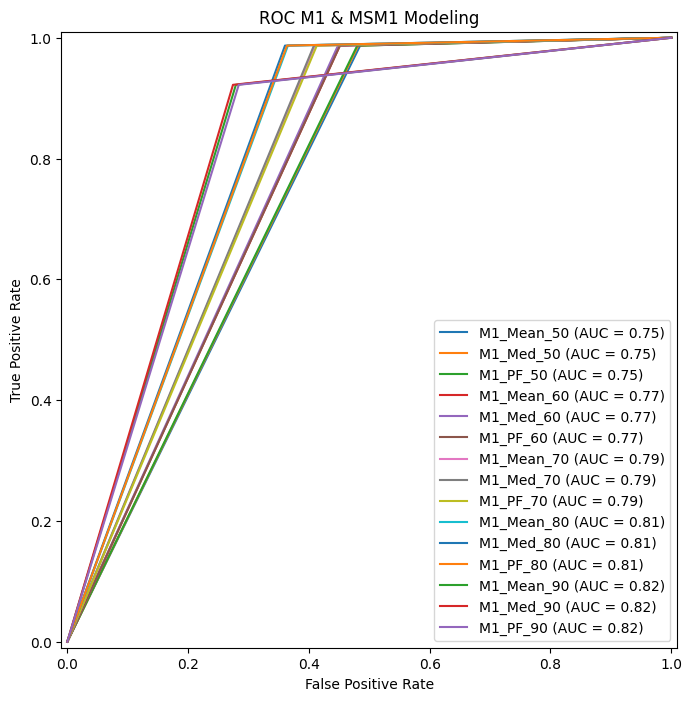

In [33]:
ground_truth_col = 'DF'
roc_results = compute_roc(ROC_df, ground_truth_col, columns_after_df)



# Optional: Plot ROC curves for each column
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
for pred_col in columns_after_df:
    fpr, tpr, _ = roc_curve(ROC_df['DF'], ROC_df[pred_col])
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc(fpr, tpr), estimator_name=pred_col).plot(ax=plt.gca())

plt.title('ROC M1 & MSM1 Modeling')
plt.legend(loc='lower right')
plt.show()

In [34]:
roc_results


,Prediction Column,TP,FP,TN,FN,Sensitivity,FPR,Specificity,Accuracy,AUC,Threat Score
0,M1_Mean_50,76,304,323,1,0.987013,0.484848,0.515152,0.566761,0.751082,0.199475
1,M1_Med_50,76,302,325,1,0.987013,0.481659,0.518341,0.569602,0.752677,0.200528
2,M1_PF_50,76,301,326,1,0.987013,0.480064,0.519936,0.571023,0.753475,0.201058
3,M1_Mean_60,76,283,344,1,0.987013,0.451356,0.548644,0.596591,0.767829,0.211111
4,M1_Med_60,76,281,346,1,0.987013,0.448166,0.551834,0.599432,0.769424,0.212291
5,M1_PF_60,76,283,344,1,0.987013,0.451356,0.548644,0.596591,0.767829,0.211111
6,M1_Mean_70,76,257,370,1,0.987013,0.409888,0.590112,0.633523,0.788562,0.227545
7,M1_Med_70,76,256,371,1,0.987013,0.408293,0.591707,0.634943,0.789360,0.228228
8,M1_PF_70,76,259,368,1,0.987013,0.413078,0.586922,0.630682,0.786967,0.226190
9,M1_Mean_80,76,229,398,1,0.987013,0.365231,0.634769,0.673295,0.810891,0.248366


In [21]:
roc_results.to_csv(r'/Volumes/PhD/imagery/masters/ROC/M1-MSM1_ROC_results_morepct.csv')


In [13]:
low_R_results = compute_roc(low_R, ground_truth_col, columns_after_df)
low_R_results

,Prediction Column,TP,FP,TN,FN,Sensitivity,FPR,Specificity,Accuracy,AUC,Threat Score
0,M1_Mean_50,27,199,323,1,0.964286,0.381226,0.618774,0.636364,0.791530,0.118943
1,M1_Med_50,27,197,325,1,0.964286,0.377395,0.622605,0.640000,0.793446,0.120000
2,M1_PF_50,27,196,326,1,0.964286,0.375479,0.624521,0.641818,0.794403,0.120536
3,M1_Mean_90,22,76,446,6,0.785714,0.145594,0.854406,0.850909,0.820060,0.211538
4,M1_Med_90,22,77,445,6,0.785714,0.147510,0.852490,0.849091,0.819102,0.209524
5,M1_PF_90,22,84,438,6,0.785714,0.160920,0.839080,0.836364,0.812397,0.196429
6,MSM1_Mean_50,27,198,324,1,0.964286,0.379310,0.620690,0.638182,0.792488,0.119469
7,MSM1_Med_50,27,197,325,1,0.964286,0.377395,0.622605,0.640000,0.793446,0.120000
8,MSM1_PF_50,27,198,324,1,0.964286,0.379310,0.620690,0.638182,0.792488,0.119469
9,MSM1_Mean_90,21,67,455,7,0.750000,0.128352,0.871648,0.865455,0.810824,0.221053


In [14]:
high_R_results = compute_roc(high_R, ground_truth_col, columns_after_df)
high_R_results

,Prediction Column,TP,FP,TN,FN,Sensitivity,FPR,Specificity,Accuracy,AUC,Threat Score
0,M1_Mean_50,73,113,1,0,1.000000,0.991228,0.008772,0.395722,0.504386,0.392473
1,M1_Med_50,73,113,1,0,1.000000,0.991228,0.008772,0.395722,0.504386,0.392473
2,M1_PF_50,73,111,3,0,1.000000,0.973684,0.026316,0.406417,0.513158,0.396739
3,M1_Mean_90,72,106,8,1,0.986301,0.929825,0.070175,0.427807,0.528238,0.402235
4,M1_Med_90,72,100,14,1,0.986301,0.877193,0.122807,0.459893,0.554554,0.416185
5,M1_PF_90,70,99,15,3,0.958904,0.868421,0.131579,0.454545,0.545242,0.406977
6,MSM1_Mean_50,73,113,1,0,1.000000,0.991228,0.008772,0.395722,0.504386,0.392473
7,MSM1_Med_50,73,113,1,0,1.000000,0.991228,0.008772,0.395722,0.504386,0.392473
8,MSM1_PF_50,73,113,1,0,1.000000,0.991228,0.008772,0.395722,0.504386,0.392473
9,MSM1_Mean_90,69,98,16,4,0.945205,0.859649,0.140351,0.454545,0.542778,0.403509


In [19]:
small_results = compute_roc(small_basins_df, ground_truth_col, columns_after_df)
small_results

,Prediction Column,TP,FP,TN,FN,Sensitivity,FPR,Specificity,Accuracy,AUC,Threat Score
0,M1_Mean_50,64,280,288,0,1.000000,0.492958,0.507042,0.556962,0.753521,0.186047
1,M1_Med_50,64,277,291,0,1.000000,0.487676,0.512324,0.561709,0.756162,0.187683
2,M1_PF_50,64,272,296,0,1.000000,0.478873,0.521127,0.569620,0.760563,0.190476
3,M1_Mean_90,61,169,399,3,0.953125,0.297535,0.702465,0.727848,0.827795,0.261803
4,M1_Med_90,61,163,405,3,0.953125,0.286972,0.713028,0.737342,0.833077,0.268722
5,M1_PF_90,59,166,402,5,0.921875,0.292254,0.707746,0.729430,0.814811,0.256522
6,MSM1_Mean_50,64,279,289,0,1.000000,0.491197,0.508803,0.558544,0.754401,0.186589
7,MSM1_Med_50,64,277,291,0,1.000000,0.487676,0.512324,0.561709,0.756162,0.187683
8,MSM1_PF_50,64,276,292,0,1.000000,0.485915,0.514085,0.563291,0.757042,0.188235
9,MSM1_Mean_90,57,152,416,7,0.890625,0.267606,0.732394,0.748418,0.811510,0.263889


In [20]:
large_results = compute_roc(large_basins_df, ground_truth_col, columns_after_df)
large_results

,Prediction Column,TP,FP,TN,FN,Sensitivity,FPR,Specificity,Accuracy,AUC,Threat Score
0,M1_Mean_50,36,32,36,1,0.972973,0.470588,0.529412,0.685714,0.751192,0.521739
1,M1_Med_50,36,33,35,1,0.972973,0.485294,0.514706,0.676190,0.743839,0.514286
2,M1_PF_50,36,35,33,1,0.972973,0.514706,0.485294,0.657143,0.729134,0.500000
3,M1_Mean_90,33,13,55,4,0.891892,0.191176,0.808824,0.838095,0.850358,0.660000
4,M1_Med_90,33,14,54,4,0.891892,0.205882,0.794118,0.828571,0.843005,0.647059
5,M1_PF_90,33,17,51,4,0.891892,0.250000,0.750000,0.800000,0.820946,0.611111
6,MSM1_Mean_50,36,32,36,1,0.972973,0.470588,0.529412,0.685714,0.751192,0.521739
7,MSM1_Med_50,36,33,35,1,0.972973,0.485294,0.514706,0.676190,0.743839,0.514286
8,MSM1_PF_50,36,35,33,1,0.972973,0.514706,0.485294,0.657143,0.729134,0.500000
9,MSM1_Mean_90,33,13,55,4,0.891892,0.191176,0.808824,0.838095,0.850358,0.660000


In [16]:
small_results.to_csv(r'/Volumes/PhD/imagery/masters/ROC/M1-MSM1_ROC_small-results.csv')
large_results.to_csv(r'/Volumes/PhD/imagery/masters/ROC/M1-MSM1_ROC_large-results.csv')

In [22]:
non_normal = pd.read_csv(r'/Volumes/PhD/imagery/masters/ROC/non-normal_roc.csv')
non_normal

,BASIN_ID,Skewed/Bimodal
0,2476,1
1,2747,0
2,2760,1
3,2832,0
4,3115,0
...,...,...
180,41594,1
181,41639,0
182,41709,1
183,41846,1


In [29]:
subset_ids = non_normal['BASIN_ID']

subset_df = ROC_df[ROC_df['BASIN_ID'].isin(subset_ids)]
NN_df = subset_df.merge(non_normal[['BASIN_ID', 'Skewed/Bimodal']], on='BASIN_ID', how='left')
#NN_df = NN_df.merge(ROC_df, on='BASIN_ID', how='left')
NN_df


,BASIN_ID,AREA,M1P_Mean,M1P_Med,M1P_PF,MSM1P_Mean,MSM1P_Med,MSM1P_PF,MSM1Pct_>50,MSM1Pct_>90,RI,Old_ROC,Skewed/Bimodal
0,3115,4.180000e+04,0.148129,0.116710,0.101142,0.167113,0.116710,0.103580,0.000000,0.000000,7.11,4,0
1,3589,4.313000e+05,0.301476,0.164258,0.122691,0.347361,0.164258,0.126322,0.350926,0.000926,7.11,4,1
2,5920,7.486600e+06,0.848432,0.870989,0.910869,0.816237,0.870989,0.913444,0.939107,0.355948,6.10,4,0
3,7185,4.314900e+06,0.866735,0.877320,0.904633,0.848268,0.877320,0.913230,0.992119,0.361487,6.10,4,0
4,12918,3.022200e+06,0.915269,0.923432,0.932539,0.903513,0.923432,0.936069,0.998809,0.701072,6.10,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,6542,2.562000e+05,0.169919,0.128443,0.121494,0.191700,0.128443,0.124673,0.068858,0.000000,6.10,0,0
177,18288,7.025000e+05,0.141669,0.147208,0.156382,0.156227,0.147208,0.080448,0.000568,0.000000,5.08,0,0
178,19058,2.172000e+05,0.123042,0.096739,0.076722,0.138916,0.096739,0.077806,0.000000,0.000000,5.08,0,1
179,15065,9.550000e+04,0.313190,0.248063,0.189564,0.340194,0.248064,0.187487,0.258333,0.000000,9.14,0,1


In [42]:
#Ground truth category
NN_df['DF'] = NN_df['Old_ROC'].apply(lambda x: 1 if x == 1 or x == 2 else 0)

#M1 ROC setup
NN_df['M1_Mean_50'] = NN_df['M1P_Mean'].apply(lambda x: 1 if x > 0.5 else 0)
NN_df['M1_Med_50'] = NN_df['M1P_Med'].apply(lambda x: 1 if x > 0.5 else 0)
NN_df['M1_PF_50'] = NN_df['M1P_PF'].apply(lambda x: 1 if x > 0.5 else 0)
NN_df['M1_Mean_90'] = NN_df['M1P_Mean'].apply(lambda x: 1 if x > 0.9 else 0)
NN_df['M1_Med_90'] = NN_df['M1P_Med'].apply(lambda x: 1 if x > 0.9 else 0)
NN_df['M1_PF_90'] = NN_df['M1P_PF'].apply(lambda x: 1 if x > 0.9 else 0)

#MSM1 ROC setup
NN_df['MSM1_Mean_50'] = NN_df['MSM1P_Mean'].apply(lambda x: 1 if x > 0.5 else 0)
NN_df['MSM1_Med_50'] = NN_df['MSM1P_Med'].apply(lambda x: 1 if x > 0.5 else 0)
NN_df['MSM1_PF_50'] = NN_df['MSM1P_PF'].apply(lambda x: 1 if x > 0.5 else 0)
NN_df['MSM1_Mean_90'] = NN_df['MSM1P_Mean'].apply(lambda x: 1 if x > 0.9 else 0)
NN_df['MSM1_Med_90'] = NN_df['MSM1P_Med'].apply(lambda x: 1 if x > 0.9 else 0)
NN_df['MSM1_PF_90'] = NN_df['MSM1P_PF'].apply(lambda x: 1 if x > 0.9 else 0)

#MSM1 ROC basin pct above 50 & 90 setup

NN_df['MSM1_Pct_50'] = NN_df['MSM1Pct_>50'].apply(lambda x: 1 if x > 0.5 else 0)
NN_df['MSM1_Pct_90'] = NN_df['MSM1Pct_>90'].apply(lambda x: 1 if x > 0.5 else 0)

In [34]:
NN_df.columns

Index(['BASIN_ID', 'AREA', 'M1P_Mean', 'M1P_Med', 'M1P_PF', 'MSM1P_Mean',
       'MSM1P_Med', 'MSM1P_PF', 'MSM1Pct_>50', 'MSM1Pct_>90', 'RI', 'Old_ROC',
       'Skewed/Bimodal', 'DF', 'M1_Mean_50', 'M1_Med_50', 'M1_PF_50',
       'M1_Mean_90', 'M1_Med_90', 'M1_PF_90', 'MSM1_Mean_50', 'MSM1_Med_50',
       'MSM1_PF_50', 'MSM1_Mean_90', 'MSM1_Med_90', 'MSM1_PF_90',
       'MSM1_Pct_50', 'MSM1_Pct_90'],
      dtype='object')

In [41]:
skewed_basins_df = NN_df[NN_df['Skewed/Bimodal'] == 0]
bimodal_basins_df = NN_df[NN_df['Skewed/Bimodal'] == 1]

bimodal_basins_df.to_csv(r'/Volumes/PhD/imagery/masters/ROC/bimodal.csv')

In [37]:
NNroc_results = compute_roc(NN_df, ground_truth_col, columns_after_df)
NNroc_results


,Prediction Column,TP,FP,TN,FN,Sensitivity,FPR,Specificity,Accuracy,AUC,Threat Score
0,M1_Mean_50,15,112,54,0,1.000000,0.674699,0.325301,0.381215,0.662651,0.082873
1,M1_Med_50,15,111,55,0,1.000000,0.668675,0.331325,0.386740,0.665663,0.082873
2,M1_PF_50,15,106,60,0,1.000000,0.638554,0.361446,0.414365,0.680723,0.082873
3,M1_Mean_90,10,39,127,5,0.666667,0.234940,0.765060,0.756906,0.715863,0.055249
4,M1_Med_90,10,37,129,5,0.666667,0.222892,0.777108,0.767956,0.721888,0.055249
5,M1_PF_90,8,43,123,7,0.533333,0.259036,0.740964,0.723757,0.637149,0.044199
6,MSM1_Mean_50,15,111,55,0,1.000000,0.668675,0.331325,0.386740,0.665663,0.082873
7,MSM1_Med_50,15,111,55,0,1.000000,0.668675,0.331325,0.386740,0.665663,0.082873
8,MSM1_PF_50,15,110,56,0,1.000000,0.662651,0.337349,0.392265,0.668675,0.082873
9,MSM1_Mean_90,6,25,141,9,0.400000,0.150602,0.849398,0.812155,0.624699,0.033149


In [38]:
skew_results = compute_roc(skewed_basins_df, ground_truth_col, columns_after_df)
skew_results

,Prediction Column,TP,FP,TN,FN,Sensitivity,FPR,Specificity,Accuracy,AUC,Threat Score
0,M1_Mean_50,15,84,26,0,1.000000,0.763636,0.236364,0.328,0.618182,0.120
1,M1_Med_50,15,83,27,0,1.000000,0.754545,0.245455,0.336,0.622727,0.120
2,M1_PF_50,15,82,28,0,1.000000,0.745455,0.254545,0.344,0.627273,0.120
3,M1_Mean_90,10,34,76,5,0.666667,0.309091,0.690909,0.688,0.678788,0.080
4,M1_Med_90,10,33,77,5,0.666667,0.300000,0.700000,0.696,0.683333,0.080
5,M1_PF_90,8,38,72,7,0.533333,0.345455,0.654545,0.640,0.593939,0.064
6,MSM1_Mean_50,15,84,26,0,1.000000,0.763636,0.236364,0.328,0.618182,0.120
7,MSM1_Med_50,15,83,27,0,1.000000,0.754545,0.245455,0.336,0.622727,0.120
8,MSM1_PF_50,15,82,28,0,1.000000,0.745455,0.254545,0.344,0.627273,0.120
9,MSM1_Mean_90,6,24,86,9,0.400000,0.218182,0.781818,0.736,0.590909,0.048


In [39]:
bimodal_results = compute_roc(bimodal_basins_df, ground_truth_col, columns_after_df)
bimodal_results

/Users/samueltaylor/Documents/GitHub/PHA_burn_severity/.venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/samueltaylor/Documents/GitHub/PHA_burn_severity/.venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/samueltaylor/Documents/GitHub/PHA_burn_severity/.venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/samueltaylor/Documents/GitHub/PHA_burn_severity/.venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/samueltaylor/Documents/GitHub/PHA_burn_severi

,Prediction Column,TP,FP,TN,FN,Sensitivity,FPR,Specificity,Accuracy,AUC,Threat Score
0,M1_Mean_50,0,28,28,0,0,0.500000,0.500000,0.500000,NaN,0.0
1,M1_Med_50,0,28,28,0,0,0.500000,0.500000,0.500000,NaN,0.0
2,M1_PF_50,0,24,32,0,0,0.428571,0.571429,0.571429,NaN,0.0
3,M1_Mean_90,0,5,51,0,0,0.089286,0.910714,0.910714,NaN,0.0
4,M1_Med_90,0,4,52,0,0,0.071429,0.928571,0.928571,NaN,0.0
5,M1_PF_90,0,5,51,0,0,0.089286,0.910714,0.910714,NaN,0.0
6,MSM1_Mean_50,0,27,29,0,0,0.482143,0.517857,0.517857,NaN,0.0
7,MSM1_Med_50,0,28,28,0,0,0.500000,0.500000,0.500000,NaN,0.0
8,MSM1_PF_50,0,28,28,0,0,0.500000,0.500000,0.500000,NaN,0.0
9,MSM1_Mean_90,0,1,55,0,0,0.017857,0.982143,0.982143,NaN,0.0
